In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import os, json
import re
import json
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd

In [45]:
# Read ExpWorkloadName from enrichment_config.yaml
ExpWorkloadName = yaml.safe_load(open("enrichment_config.yaml"))["ExpWorkloadName"]
print("ExpWorkloadName:", ExpWorkloadName)

# Analysis Inputs
system_name = "pg_heavy_results" # CHANGE FOR NEW SYSTEM
throughput_str = "pgh_thr2885"
exp_name = "{}/{}".format(system_name, throughput_str)
log_files = glob.glob(f"results/{exp_name}/*.csv")
print(exp_name)

df = pd.concat([pd.read_csv(log_file, names=['tid', 'this_nid', 'logged_time'], usecols=[0, 1, 2]) for log_file in log_files], ignore_index=True)
df['logged_time'] = pd.to_numeric(df['logged_time'], errors='coerce')
# print(df.head())

# Adjust for warmup and cooldown
start_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].min()
end_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].max()
print("Start time of test:", start_time_of_test)
total_test_time = end_time_of_test - start_time_of_test
lower_cutoff = start_time_of_test + 0.10 * total_test_time
upper_cutoff = start_time_of_test + 0.90 * total_test_time
time_window_seconds = (upper_cutoff - lower_cutoff) / 1000000
print("Time window (seconds):", time_window_seconds)


# Getting valid/completed tids
print("Expworkloadname:", ExpWorkloadName)
tid_logger_nodes = json.load(open(f"enrichment_runs/{ExpWorkloadName}/tid_to_logger_nodes.json"))
invalid_tids_count = 0

def valid_group(group):
    """Returns True if a group contains logs from ALL expected logger nodes for that TID."""
    global invalid_tids_count

    tid = group['tid'].iloc[0]  # Extract TID from the group
    client_times = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time']

    if client_times.empty:
        return False

    # Check if all logger nodes for this TID exist in the group
    expected_logger_nodes = set(tid_logger_nodes.get(tid, []))
    actual_logger_nodes = set(group['this_nid'].unique())

    if not expected_logger_nodes.issubset(actual_logger_nodes):
        invalid_tids_count += 1
        return False

    # Keep the group only if at least one mewbie_client logged_time is within the cutoffs
    return ((client_times >= lower_cutoff) & (client_times <= upper_cutoff)).any()

df = df.groupby('tid').filter(valid_group)
num_tids_after_filter = df['tid'].nunique()
print("Number of tids after filtering:", num_tids_after_filter)
print("Number of invalid tids:", invalid_tids_count)

# Completion rate throughput
c_throughput = num_tids_after_filter / time_window_seconds
print("Completion rate throughput:", c_throughput)

rct_results = []
grouped_df = df.groupby('tid')

for tid, group in tqdm(grouped_df, desc="Processing for RCT calc..."):
    max_time = group['logged_time'].max()
    start_time = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time'].min()
    if pd.notna(start_time):
        rct = (max_time - start_time) / 1000
        rct_results.append(rct)

throughput_str = f"{int(c_throughput)}"
new_exp_name = re.sub(r'\d+$', throughput_str, exp_name)
print("New exp_name:", new_exp_name)


with open(f"results/{new_exp_name}_rct_new.json", "w") as f:
    json.dump(rct_results, f)


ExpWorkloadName: dmix1_pg_heavy
pg_heavy_results/pgh_thr2885
Start time of test: 1741625451460318
Time window (seconds): 24.0469585
Expworkloadname: dmix1_pg_heavy
Number of tids after filtering: 69011
Number of invalid tids: 328
Completion rate throughput: 2869.8431861975396


Processing for RCT calc...: 100%|██████████| 69011/69011 [00:30<00:00, 2278.78it/s]


New exp_name: pg_heavy_results/pgh_thr2869


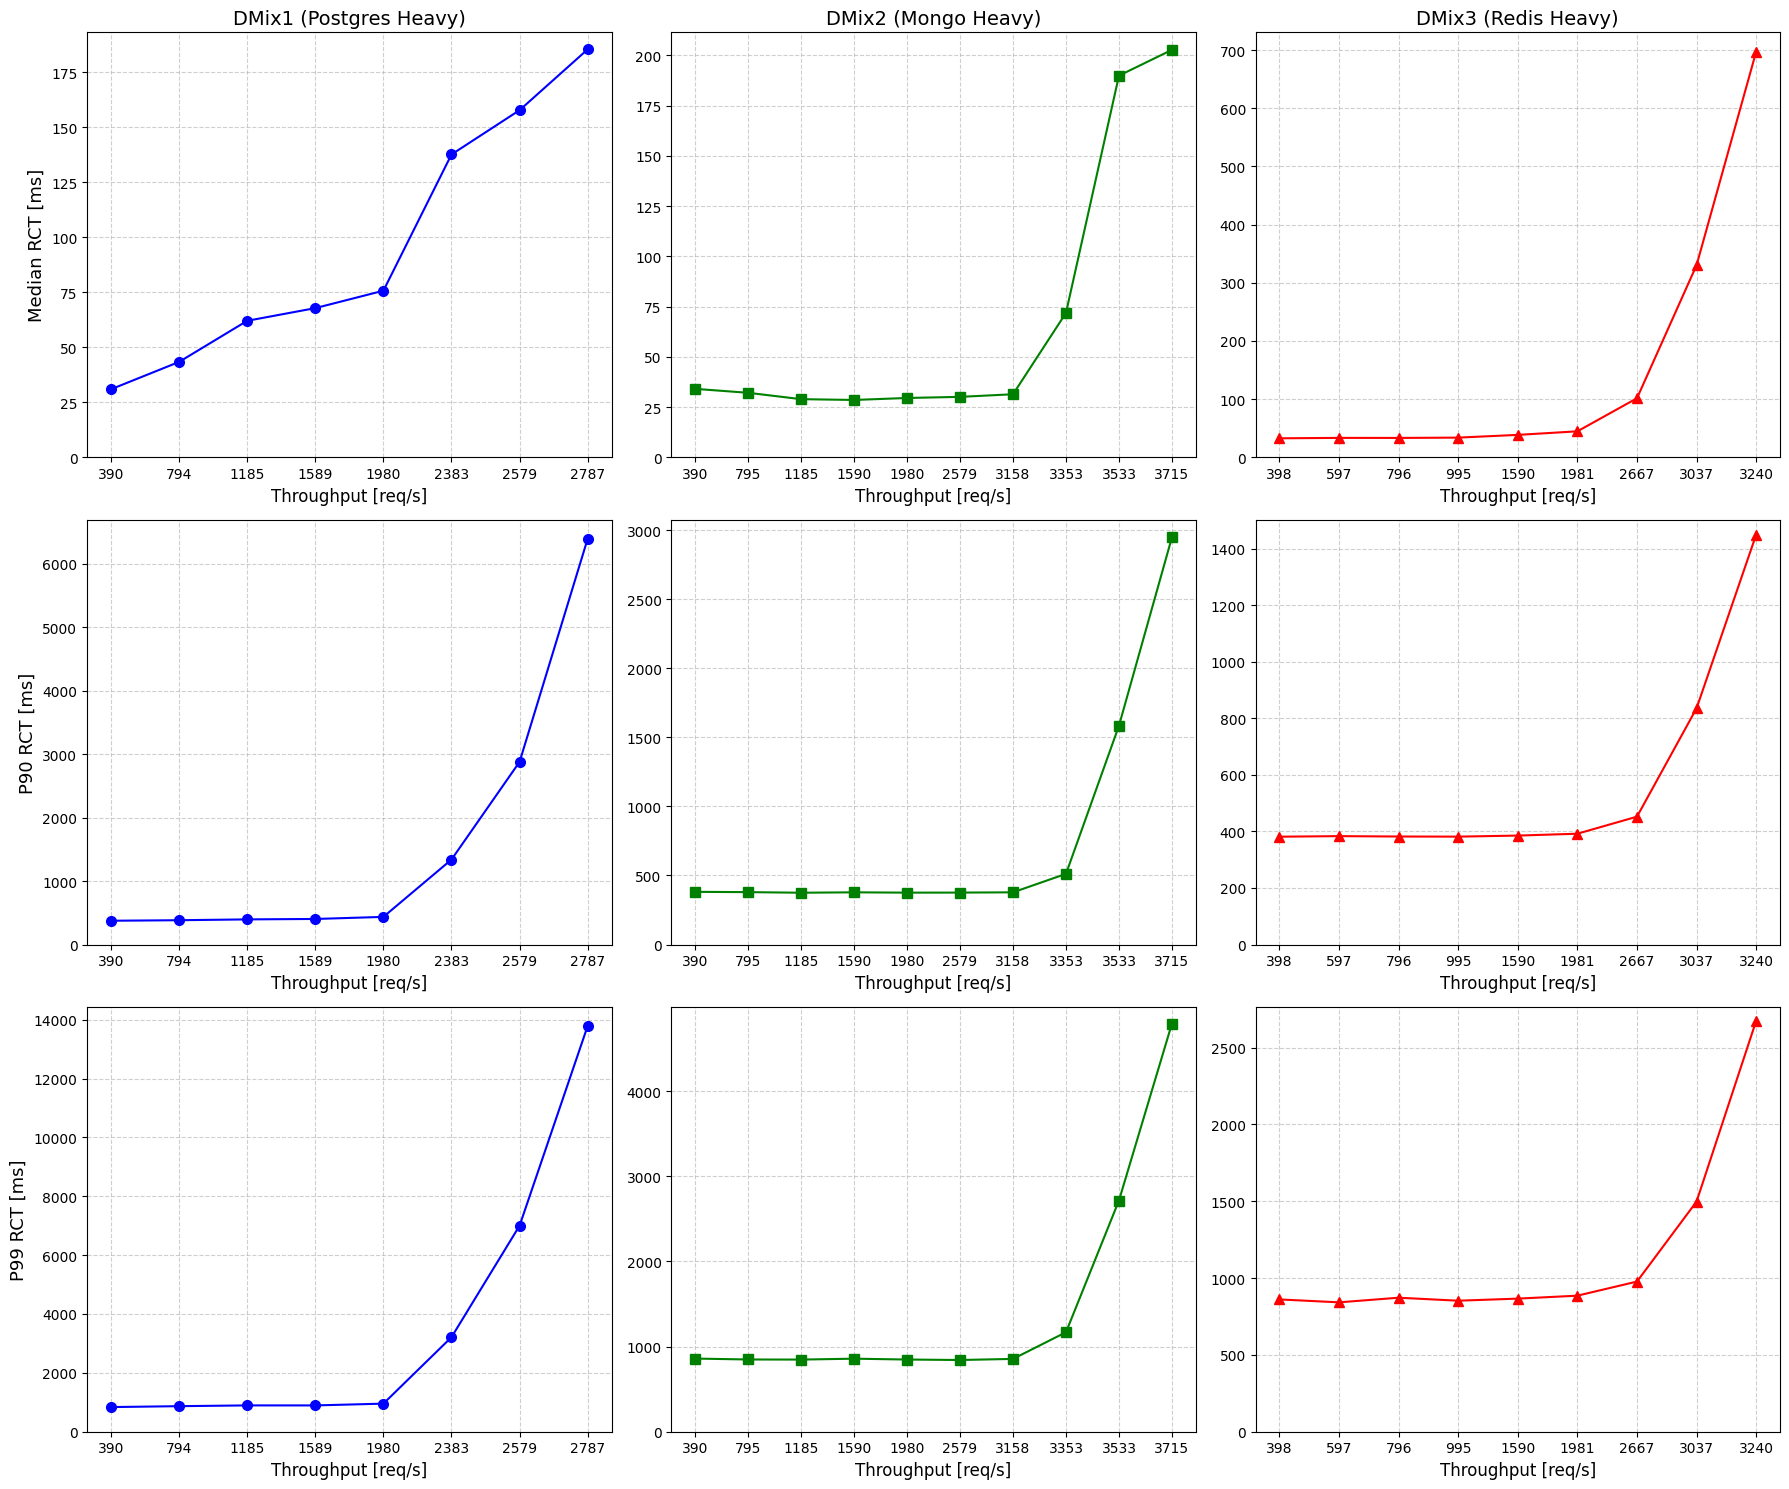

In [47]:
#****************************************************
#### FOR TESTING
#****************************************************

def read_rct_data(dir_name, exp_name):
    '''
    return: dict; key: exp_thr, value: list of rct results
    '''
    # eg: dir_name = 'pg_heavy_results', eg: file_name = 'pgh_thr100_rct.json'
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            match = re.search(r'thr(\d+)_', file)
            exp_thr = match.group(1) 
            with open(os.path.join(dir_name, file), 'r') as f:
                res = json.load(f)
            rct_results[exp_thr] = res
    return (exp_name, rct_results)

pg_rct_res = read_rct_data("./results/pg_heavy_results", "DMix1 (Postgres Heavy)")
mongo_rct_res = read_rct_data("./results/mongo_heavy_results", "DMix2 (Mongo Heavy)")
redis_rct_res = read_rct_data("./results/redis_heavy_results", "DMix3 (Redis Heavy)")
rct_vs_thr_exp_input = [pg_rct_res, mongo_rct_res, redis_rct_res]

def gen_percentile_values(rct_vs_thr_exp_input):
    exp_output = {} # key: exp (eg: pg_heavy), value: dict; key: median/p90/p99 value: {thr: rct value, ...}
    for exp, dets in rct_vs_thr_exp_input:
        exp_output[exp] = {}
        for thr, rct_vals in dets.items():
            # if exp not in exp_output:
            #     exp_output[exp] = {}
            exp_output[exp][thr] = {}
            rct_median = np.median(rct_vals)
            rct_p90 = np.percentile(rct_vals, 90)
            rct_p99 = np.percentile(rct_vals, 99)
            exp_output[exp][thr]['median'] = rct_median
            exp_output[exp][thr]['p90'] = rct_p90
            exp_output[exp][thr]['p99'] = rct_p99
    return exp_output

exp_output = gen_percentile_values(rct_vs_thr_exp_input)

def plot_9_separate_subplots(data, title_suffix="RCT"):
    """
    Plot 9 separate subplots arranged in 3 rows and 3 columns:
    - Rows: Percentiles (Median, P90, P99)
    - Columns: Workloads (Postgres, Mongo, Redis)
    
    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']  
    workloads = list(data.keys())  
    colors = ['b', 'g', 'r']  # Colors for lines
    markers = ['o', 's', '^']  # Markers for lines
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 3 rows, 3 columns
    
    for row_idx, percentile in enumerate(percentiles):
        for col_idx, workload in enumerate(workloads):
            ax = axes[row_idx, col_idx]
            workload_data = data[workload]
            x = sorted(workload_data.keys(), key=lambda k: int(k))  # Sort throughput keys
            y = [workload_data[thr][percentile] for thr in x]  # Extract RCT values
            
            # Plot data
            ax.plot(
                x, y,
                color=colors[col_idx % len(colors)],
                marker=markers[col_idx % len(markers)],
                markersize=7,
                label=f'{percentile.capitalize()}'
            )
            
            # Set labels, titles, and grid
            if row_idx == 0:
                ax.set_title(f'{workload}', fontsize=14)
            if col_idx == 0:
                ax.set_ylabel(f'{percentile.capitalize()} RCT [ms]', fontsize=13)
            ax.set_xlabel('Throughput [req/s]', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_yscale('linear')
            ax.set_ylim(0)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_9_separate_subplots(exp_output)

### Throughput vs RCT Analysis

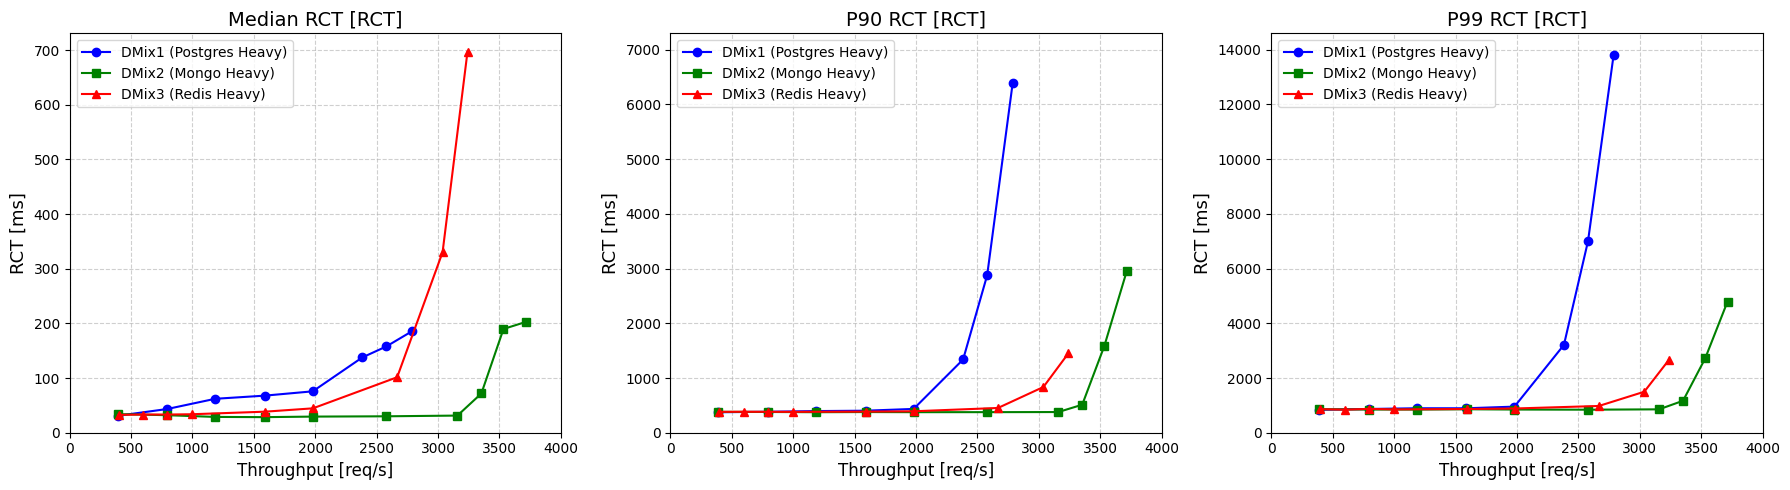

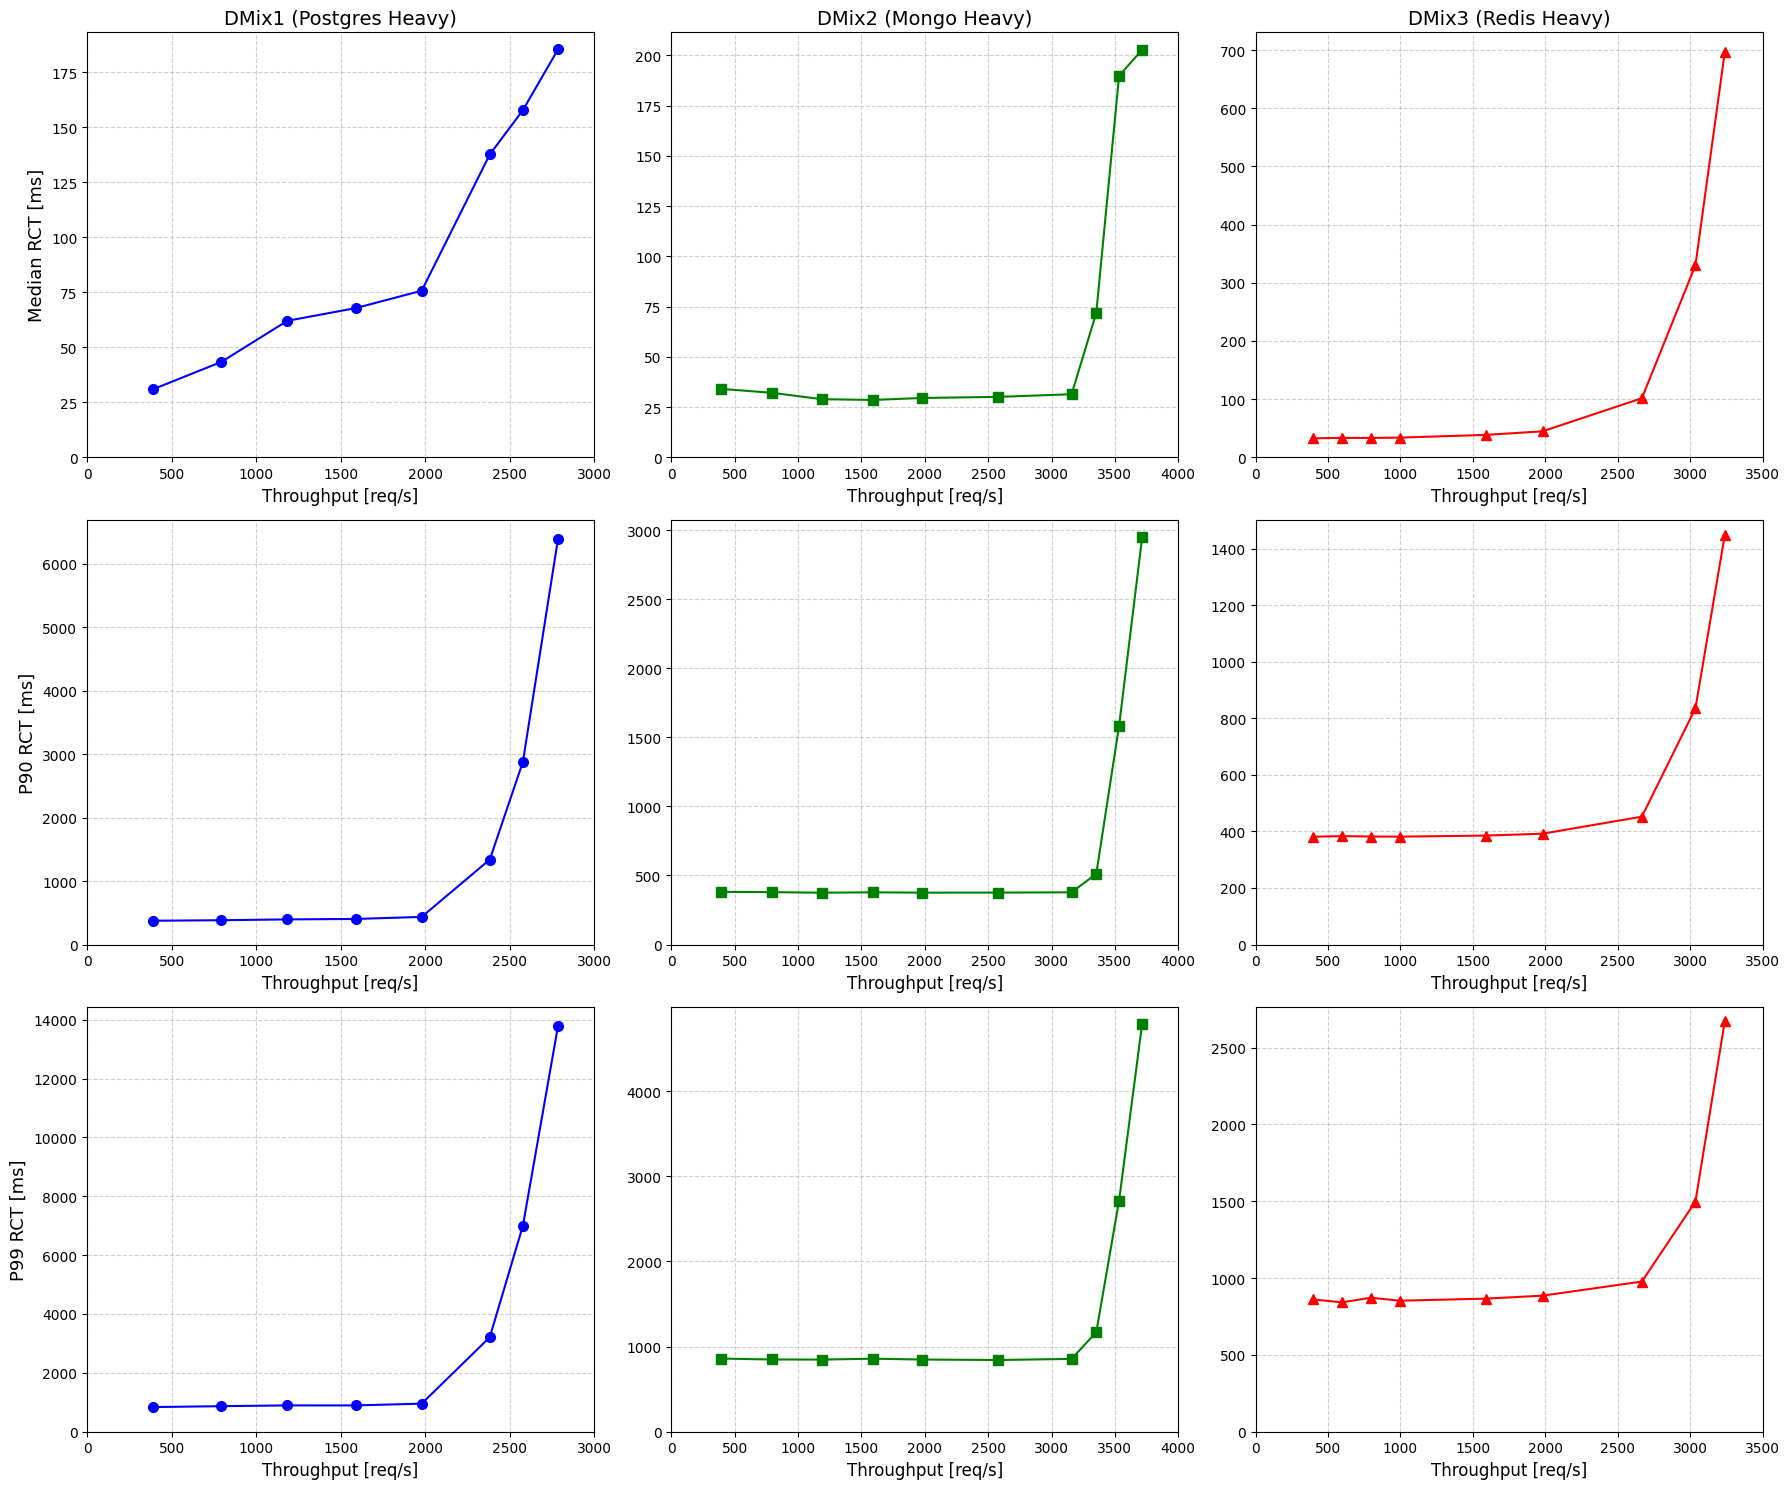

In [5]:
def read_rct_data(dir_name, exp_name):
    '''
    return: dict; key: exp_thr, value: list of rct results
    '''
    # eg: dir_name = 'pg_heavy_results', eg: file_name = 'pgh_thr100_rct.json'
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            match = re.search(r'thr(\d+)_', file)
            exp_thr = match.group(1) 
            with open(os.path.join(dir_name, file), 'r') as f:
                res = json.load(f)
            rct_results[exp_thr] = res
    return (exp_name, rct_results)

pg_rct_res = read_rct_data("./results/pg_heavy_results", "DMix1 (Postgres Heavy)")
mongo_rct_res = read_rct_data("./results/mongo_heavy_results", "DMix2 (Mongo Heavy)")
redis_rct_res = read_rct_data("./results/redis_heavy_results", "DMix3 (Redis Heavy)")
rct_vs_thr_exp_input = [pg_rct_res, mongo_rct_res, redis_rct_res]

def gen_percentile_values(rct_vs_thr_exp_input):
    exp_output = {} # key: exp (eg: pg_heavy), value: dict; key: median/p90/p99 value: {thr: rct value, ...}
    for exp, dets in rct_vs_thr_exp_input:
        exp_output[exp] = {}
        for thr, rct_vals in dets.items():
            # if exp not in exp_output:
            #     exp_output[exp] = {}
            exp_output[exp][thr] = {}
            rct_median = np.median(rct_vals)
            rct_p90 = np.percentile(rct_vals, 90)
            rct_p99 = np.percentile(rct_vals, 99)
            exp_output[exp][thr]['median'] = rct_median
            exp_output[exp][thr]['p90'] = rct_p90
            exp_output[exp][thr]['p99'] = rct_p99
    return exp_output

exp_output = gen_percentile_values(rct_vs_thr_exp_input)
def plot_3_combined_graphs(data, title_suffix="RCT"):
    """
    Plot 3 separate graphs (one for each percentile: median, p90, p99).
    Each graph contains multiple workloads as separate lines.

    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']
    workloads = list(data.keys())
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Unique colors for different workloads
    markers = ['o', 's', '^', 'D', 'x', 'P', '*']  # Unique markers for workloads

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns for three graphs

    for idx, percentile in enumerate(percentiles):
        ax = axes[idx]

        # Find the overall x-axis range across all workloads
        all_x_values = sorted({int(k) for workload in workloads for k in data[workload].keys()})
        x_min, x_max = min(all_x_values), max(all_x_values)

        for i, workload in enumerate(workloads):
            workload_data = data[workload]

            # Convert throughput keys to integers and sort
            x = sorted([int(k) for k in workload_data.keys()])
            y = [workload_data[str(thr)][percentile] for thr in x]  # Extract RCT values

            # Plot each workload on the same graph
            ax.plot(
                x, y,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                markersize=6,
                label=f'{workload}'
            )

        # Set labels, titles, and grid
        ax.set_title(f'{percentile.capitalize()} RCT [{title_suffix}]', fontsize=14)
        ax.set_xlabel('Throughput [req/s]', fontsize=12)
        ax.set_ylabel('RCT [ms]', fontsize=13)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_yscale('linear')
        ax.set_ylim(0)
    
        if percentile == 'p90':
            ax.set_ylim(0, 7300)  # *** Fixed max y-axis for p90 ***
        else:
            ax.set_ylim(0)
        if percentile == 'p99':
            ax.set_ylim(0, 14600)  # *** Fixed max y-axis for p90 ***
        else:
            ax.set_ylim(0)

        # Set x-axis ticks at rounded intervals
        tick_interval = 500  # Adjust if needed
        ax.set_xticks(np.arange(0, x_max + tick_interval, tick_interval))

        # Add legend
        ax.legend(fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_9_separate_subplots(data, title_suffix="RCT"):
    """
    Plot 9 separate subplots arranged in 3 rows and 3 columns:
    - Rows: Percentiles (Median, P90, P99)
    - Columns: Workloads (Postgres, Mongo, Redis)
    
    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']  
    workloads = list(data.keys())  
    colors = ['b', 'g', 'r']  # Colors for lines
    markers = ['o', 's', '^']  # Markers for lines
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 3 rows, 3 columns
    
    for row_idx, percentile in enumerate(percentiles):
        for col_idx, workload in enumerate(workloads):
            ax = axes[row_idx, col_idx]
            workload_data = data[workload]

            # Convert throughput keys to integers and sort
            x = sorted([int(k) for k in workload_data.keys()])
            y = [workload_data[str(thr)][percentile] for thr in x]  # Extract RCT values
            
            # Plot data
            ax.plot(
                x, y,
                color=colors[col_idx % len(colors)],
                marker=markers[col_idx % len(markers)],
                markersize=7,
                label=f'{percentile.capitalize()}'
            )
            
            # Set labels, titles, and grid
            if row_idx == 0:
                ax.set_title(f'{workload}', fontsize=14)
            if col_idx == 0:
                ax.set_ylabel(f'{percentile.capitalize()} RCT [ms]', fontsize=13)
            ax.set_xlabel('Throughput [req/s]', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_yscale('linear')
            ax.set_ylim(0)
            
            # Set x-axis ticks at rounded intervals
            tick_interval = 500  # Adjust if necessary
            x_min, x_max = min(x), max(x)
            ax.set_xticks(np.arange(0, x_max + tick_interval, tick_interval))

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_3_combined_graphs(exp_output)
plot_9_separate_subplots(exp_output)

## Getting Hot Nodes